# Description: 


* **CONTEXT:** 

* **DATA DESCRIPTION:**  
• author : name of the person who gave the rating  
• country : country the person who gave the rating belongs to  
• data : date of the rating  
• domain: website from which the rating was taken from  
• extract: rating content  
• language: language in which the rating was given  
• product: name of the product/mobile phone for which the rating was given  
• score: average rating for the phone  
• score_max: highest rating given for the phone  
• source: source from where the rating was taken  

* **PROJECT OBJECTIVE:** We will build a recommendation system using popularity based and collaborative filtering methods to recommend mobile phones to a user which are most popular and personalised respectively.

## Table of Contents <a id="toc"></a>
* [# Import Libraries](#import_libraries)  
1. [Data Prepration and cleaning](#data_prepration)  
    1.1. [Load the dataset](#load_data)  
    1.2. [Merge dataset](#merge_data)  
    1.3. [Basic Analysis](#basic_analysis)  
    1.4. [Modification 1: revs1: Data cleaning, Imputation and rounding-off](#clean_impute_round-off)  
    1.5. [Data split](#data_split)  
2. [Analysis](#analysis)
3. [Recommend top 5 mobile phones using popularity based model](#popularity_model)
4. [Collaborative filtering based models](#collaborative_filtering)  
    4.1 [SVD](#svd)  
    4.2 [kNNWithMeans_Item based](#knnwithmeans_item_based)  
    4.3 [kNNWithMeans_User based](#knnwithmeans_user_based)  
5. [Show RMSE value and comparison](#rmse)  
6. [Average ratings for test users](#average_rating)  
7. [Summary (findings and Inferences)](#summary_inferences)
8. [Recommend top 5 products for test users](#recommend_top_5)  
9. [Results with cross_validation techniques](#cross_validation)  
10. [In what business scenario you should use popularity based Recommendation Systems?](#q10)  
11. [In what business scenario you should use CF based Recommendation Systems ?](#q11)
12. [What other possible methods can you think of which can further improve the recommendation for different users ?](#q12)

## #. Import libraries <a id="import_libraries"></a>
[Go to top](#toc)

[Go to top](#toc)

In [1]:
# Main libraries
import os
import pandas as pd
import numpy as np

In [2]:
# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

In [3]:
# Libraries for recommendation systems
from collections import defaultdict
from surprise import SVD
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [63]:
# !pip install translate
# !pip install google-trans-new

In [4]:
from google_trans_new import google_translator
from translate import Translator

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
pd.set_option("display.max_rows", 50, "display.max_columns", 50)
pd.set_option('display.max_colwidth', None)
plt.style.use('bmh')
# create contants
RS=612

## 1. Data preparation and basic cleaning <a id="data_prepration"></a>
[Go to top](#toc)

[Go to top](#toc)

### 1.1.  Load the dataset <a id="load_data"></a>
[Go to top](#toc)

In [7]:
%%time
#Loading Data files
review_1 = pd.read_csv('feedbacksmall.csv')
review_2 = pd.read_csv('feedback.csv')


CPU times: total: 2.45 s
Wall time: 2.46 s


In [8]:
review_1.head()

,productid,rate,cmt,username,productname
0,626fc73b92862a001100054e,5,Very beautiful phone 📱,Naugachhia,Nokia 105 SS
1,626fc73b92862a001100054e,3,Good,Darbhanga,Nokia 105 SS
2,626fc73b92862a0011000566,5,Excellent for battery life and Display. Nice smartphone from samsung.,Mandir Hasaud,"SAMSUNG Galaxy M33 5G (Deep Ocean Blue, 128 GB)"
3,626fc73b92862a0011000566,4,God awasome phone in this price,Mokokchung,"SAMSUNG Galaxy M33 5G (Deep Ocean Blue, 128 GB)"
4,626fc73b92862a0011000566,5,"Above par, worth for money",Madurai,"SAMSUNG Galaxy M33 5G (Deep Ocean Blue, 128 GB)"


In [9]:
review_2.head()

,productid,rate,cmt,username,productname
0,626fc73b92862a00110004bd,4,"This is best budget phone.... Poco C31, and order this product because I have Poco M2 Reloaded, i was gift this phone to my sister on her birthday, she loved it",Kavi Lama,"POCO C31 (Royal Blue, 64 GB)"
1,626fc73b92862a00110004bd,3,Pros :,MOKIM SARKAR,"POCO C31 (Royal Blue, 64 GB)"
2,626fc73b92862a00110004bd,5,The best budget phone. Camera clarity is good. Value for money. Right size phone with light weight. Over all good phone with budget price.,Suresh Kumar.k,"POCO C31 (Royal Blue, 64 GB)"
3,626fc73b92862a00110004bd,3,Not soo gud.... Average phone...,Ankur Dhawan,"POCO C31 (Royal Blue, 64 GB)"
4,626fc73b92862a00110004bd,5,"Outstanding phone at a very outstanding price....it's performance, battery,camera is very good it has nice interface and anyone can easily use it...i didn't expected this product to be this good..but it's on the next level...I am very happy that I bought it..",Ayub Mulla,"POCO C31 (Royal Blue, 64 GB)"


In [10]:
print(f'review_1: Rows: {review_1.shape[0]} and Columns: {review_1.shape[1]}\n')
print(f'review_2: Rows: {review_2.shape[0]} and Columns: {review_2.shape[1]}\n')

print(f'Total rows: {review_1.shape[0]+review_2.shape[0]}')

review_1: Rows: 597 and Columns: 5

review_2: Rows: 1658160 and Columns: 5

Total rows: 1658757


In [11]:
print('Check whether the column names are same in all the dataframes: ')
all(np.unique(review_1.columns.tolist()) == np.unique(review_1.columns.tolist()+
                                                      review_2.columns.tolist()
                                                ))

Check whether the column names are same in all the dataframes: 


True

### 1.2. Merge dataset <a id="merge_data"></a>
[Go to top](#toc)

In [12]:
#Merge the data into a single dataframe 
reviews = pd.concat([review_1,review_2], ignore_index=True)
del review_1, review_2
print(f'reviews: Rows: {reviews.shape[0]} and Columns: {reviews.shape[1]}\n')
print('Top 5 rows of the data: ')
display(reviews.head())
print('Bottom 5 rows of the data: ')
display(reviews.tail())

reviews: Rows: 1658757 and Columns: 5

Top 5 rows of the data: 


,productid,rate,cmt,username,productname
0,626fc73b92862a001100054e,5,Very beautiful phone 📱,Naugachhia,Nokia 105 SS
1,626fc73b92862a001100054e,3,Good,Darbhanga,Nokia 105 SS
2,626fc73b92862a0011000566,5,Excellent for battery life and Display. Nice smartphone from samsung.,Mandir Hasaud,"SAMSUNG Galaxy M33 5G (Deep Ocean Blue, 128 GB)"
3,626fc73b92862a0011000566,4,God awasome phone in this price,Mokokchung,"SAMSUNG Galaxy M33 5G (Deep Ocean Blue, 128 GB)"
4,626fc73b92862a0011000566,5,"Above par, worth for money",Madurai,"SAMSUNG Galaxy M33 5G (Deep Ocean Blue, 128 GB)"


Bottom 5 rows of the data: 


,productid,rate,cmt,username,productname
1658752,626fc73b92862a0011000867,5,Ideal according to price.,Afif Hossain,"POCO M2 Pro (Two Shades of Black, 64 GB)"
1658753,626fc73b92862a0011000867,4,Good not better,Flipkart Customer,"POCO M2 Pro (Two Shades of Black, 64 GB)"
1658754,626fc73b92862a0011000867,2,after 15 days receiver of this phone is damaged 🙁,D C Gupta,"POCO M2 Pro (Two Shades of Black, 64 GB)"
1658755,626fc73b92862a0011000867,5,12000 main best ha,Keishna Chetry,"POCO M2 Pro (Two Shades of Black, 64 GB)"
1658756,626fc73b92862a0011000867,4,Value for money,Shiva Kumar,"POCO M2 Pro (Two Shades of Black, 64 GB)"


In [13]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1658757 entries, 0 to 1658756
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   productid    1643466 non-null  object
 1   rate         1658757 non-null  int64 
 2   cmt          1658757 non-null  object
 3   username     1658737 non-null  object
 4   productname  1658757 non-null  object
dtypes: int64(1), object(4)
memory usage: 63.3+ MB


* Except **rate**  (which are of float type) all other features are of object type 
* Also, **score, score_max, extract and author**: columns seems to have Null values

### 1.3. Basic analysis <a id="basic_analysis"></a>
[Go to top](#toc)

In [14]:
df=reviews.isna().sum().round(2)
df1 = (df*100/reviews.shape[0]).round(2)
print('Missing count and percentages for each column are: \n',df.astype('str') +' ('+ df1.astype('str')+'%)')

fig = px.bar(x=df.index, y=df1,text = df.astype('str') +'('+ df1.astype('str')+'%)',
            title="Count (text) and Percentage(yaxis) of missing values in all the features (data: reviews)")
fig.update_xaxes(title_text= 'Features')
fig.update_yaxes(title_text= 'Percentage of Missing values')
fig.show()
del df, df1

Missing count and percentages for each column are: 
 productid      15291 (0.92%)
rate                0 (0.0%)
cmt                 0 (0.0%)
username           20 (0.0%)
productname         0 (0.0%)
dtype: object


Thus these three features have approx 4.5% missing values
'score' and 'score_max' have exactly same number of missing values

In [15]:
print('Number of unique values in each feature: \n',reviews.nunique())

Number of unique values in each feature: 
 productid        1085
rate                5
cmt            358514
username       392571
productname      1163
dtype: int64


In [17]:
reviews['productname'].shape

(1658757,)

Distribution of number of ratings per item (Clipped at 10): 
 realme 8 (Cyber Silver, 128 GB)           29406
LAVA A1                                   23740
SAMSUNG Guru Music 2                      23721
POCO M3 (Cool Blue, 64 GB)                18755
realme 8 (Cyber Black, 128 GB)            17602
Micromax X741                             14643
realme Narzo 30 (Racing Silver, 64 GB)    14498
Kechaoda K115                             14455
I Kall K3310                              13846
Nokia 105 SS 2021                         11938
Name: productname, dtype: int64


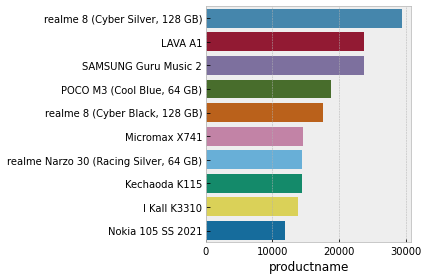

In [18]:
product = reviews['productname'].value_counts()[:10]
print('Distribution of number of ratings per item (Clipped at 10): \n',product)
sns.barplot(y=product.index,x=product)
plt.tight_layout()
plt.show()

Distribution of number of ratings per user(Clipped at 10): 
 Flipkart Customer    325385
Deepak Kumar           1351
Amit Kumar             1211
Rahul Kumar            1182
Ajay Kumar              869
Manish Kumar            828
Anil Kumar              806
Abhishek Kumar          796
Pankaj Kumar            777
Ravi Kumar              760
Name: username, dtype: int64


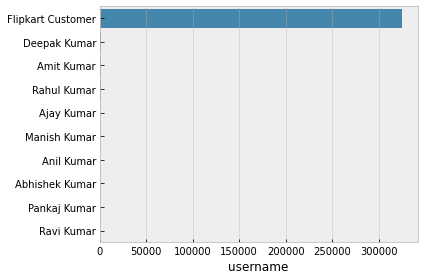

In [19]:
users = reviews['username'].value_counts(dropna=False)[:10]
print('Distribution of number of ratings per user(Clipped at 10): \n',users)
users.index = users.index.map(str)
sns.barplot(y=users.index,x=users)
plt.tight_layout()
plt.show()

Following observations are made:  
1. Most active user is 'Flipkart customer'
2. 'Anonymous' and 'unknown' users are those whose names are not known. Thus we can use this to impute blank values in 'username' column


names like 'einer Kundin', 'einem Kunden','Anonymous' and 'unknown' can be interpreted in the same way i.e. an 'unknown customer'. Let's replace these names too

In [20]:
unknowns = ['anonymous']
reviews['username'].replace(to_replace = unknowns, 
                          value = 'Anonymous', 
                          inplace=True)

Distribution of number of ratings per user(Clipped at 10): 
 Flipkart Customer    325385
Deepak Kumar           1351
Amit Kumar             1211
Rahul Kumar            1182
Ajay Kumar              869
Manish Kumar            828
Anil Kumar              806
Abhishek Kumar          796
Pankaj Kumar            777
Ravi Kumar              760
Name: username, dtype: int64


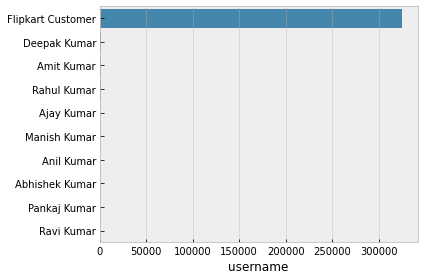

In [21]:
users = reviews['username'].value_counts(dropna=False)[:10]
print('Distribution of number of ratings per user(Clipped at 10): \n',users)
users.index = users.index.map(str)
sns.barplot(y=users.index,x=users)
plt.tight_layout()
plt.show()

In [23]:
# Let's check the score column of the data
print('Uniqe values in the "score" feature: \n',reviews.rate.unique())

Uniqe values in the "score" feature: 
 [5 3 4 1 2]


Let's round it off to nearest integer

In [24]:
relevant_features=['username','productname','rate']


In [25]:
print('Number of duplicate rows: ', reviews.duplicated().sum())

Number of duplicate rows:  205758


In [27]:
orgnl_rows = reviews.shape[0]
orgnl_columns = reviews.shape[1]

print(orgnl_columns)
print(orgnl_rows)

5
1658757


### 1.4. Modification 1: revs1: Data cleaning, Imputation and rounding-off <a id="clean_impute_round-off"></a>
[Go to top](#toc)

In [28]:
revs1 = reviews.copy()

# Delete data which is not useful anymore, to save memory
del reviews

# Step1: remove irrelevant features
revs1 = revs1.loc[:,relevant_features]
print(f'Step1: revs1 Shape after removing irrelevant features: Rows: {revs1.shape[0]} and Columns: {revs1.shape[1]}\n')

# Step2: Round-off score feature to nearest integer
revs1['rate'] = revs1['rate'].round(0).astype('Int64')
print('Step2: Round-off: Unique values in the "score" feature(after rounding-off): \n',list(revs1.rate.unique()))

# Step3: Impute missing values in score feature with median
revs1['rate'] = revs1['rate'].fillna(revs1['rate'].median())
print('\nStep3: Imputation of "rate"  with median and "username" with "Anonymous"')

# Step4: remove samples with missing values in 'Product' and 'author' feature and also 'Anonymous' values
revs1.dropna(inplace=True)
revs1 = revs1[revs1["username"] != 'Anonymous']
print(f'\nStep4: revs1 Shape(after removing missing values): Rows: {revs1.shape[0]} and Columns: {revs1.shape[1]}\n')

# Step5: remove duplicates, if any
revs1 = revs1.drop_duplicates()
print(f'Step5: revs1 Shape(after removing duplicates): Rows: {revs1.shape[0]} and Columns: {revs1.shape[1]}\n')

print(f'Overall {round(100 - revs1.shape[0]*100/orgnl_rows,2)}% samples are dropped\n')
revs1.head()

Step1: revs1 Shape after removing irrelevant features: Rows: 1658757 and Columns: 3

Step2: Round-off: Unique values in the "score" feature(after rounding-off): 
 [5, 3, 4, 1, 2]

Step3: Imputation of "rate"  with median and "username" with "Anonymous"

Step4: revs1 Shape(after removing missing values): Rows: 1658729 and Columns: 3

Step5: revs1 Shape(after removing duplicates): Rows: 1205792 and Columns: 3

Overall 27.31% samples are dropped



,username,productname,rate
0,Naugachhia,Nokia 105 SS,5
1,Darbhanga,Nokia 105 SS,3
2,Mandir Hasaud,"SAMSUNG Galaxy M33 5G (Deep Ocean Blue, 128 GB)",5
3,Mokokchung,"SAMSUNG Galaxy M33 5G (Deep Ocean Blue, 128 GB)",4
4,Madurai,"SAMSUNG Galaxy M33 5G (Deep Ocean Blue, 128 GB)",5


### 1.5. Data split <a id="data_split"></a>
[Go to top](#toc)

In [94]:
# separate 1 million data samples
revs_1m = revs1.sample(n=1000000, random_state=RS)
print(f'revs2 Shape: Rows: {revs_1m.shape[0]} and Columns: {revs_1m.shape[1]}\n')

revs2 Shape: Rows: 1000000 and Columns: 3



## 2. Analysis <a id="analysis"></a>
[Go to top](#toc)

In [95]:
# 1. Most rated features
print('Most rated features/products: \n\n',revs_1m['productname'].value_counts().head())

Most rated features/products: 

 samsung galaxy s5         11429
samsung galaxy s6         11046
motorola moto g           10382
samsung galaxy s7 edge    10359
apple iphone 5s           10281
Name: product, dtype: int64


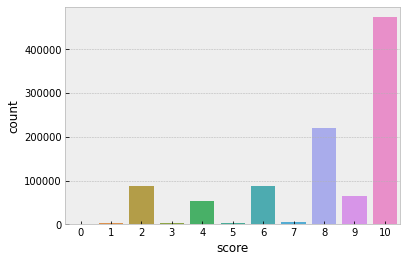

In [96]:
# find out which rating is given highest number of times
sns.countplot(data=revs_1m , x='rate')
plt.show()

In [97]:
revs1[revs1['rate']==10]['username'].value_counts().head(10)

Amazon Customer    1530
Cliente Amazon      519
Amazon Kunde        422
Client d'Amazon     301
David               292
Alex                274
Daniel              258
Marco               229
Chris               228
Michael             210
Name: author, dtype: int64

In [98]:
# 2. Users with highest number of reviews
print('Users with highest number of reviews: \n\n',revs_1m['username'].value_counts().head())

Users with highest number of reviews: 

 Amazon Customer    4816
Cliente Amazon     1663
Amazon Kunde       1179
Client d'Amazon     975
David               558
Name: author, dtype: int64


In [99]:
# 3. Select data with products having >50 ratings and users who have given > 50 ratings
author50 = revs1['username'].value_counts()
author50 = author50[author50>50].index.tolist() # list of authors with > 50 ratings
print('Number of authors who have given >50 rating: ', len(author50))

product50 = revs1['productname'].value_counts()
product50 = product50[product50>50].index.tolist() # list of products with > 50 ratings
print('Number of products with >50 rating: ', len(product50))

revs_50 = revs1[(revs1['username'].isin(author50)) & (revs1['productname'].isin(product50))]
print(f'\nrevs_50: Rows: {revs_50.shape[0]} and Columns: {revs_50.shape[1]}\n')
del author50, product50
revs_50.head()

Number of authors who have given >50 rating:  805
Number of products with >50 rating:  2496

revs_50: Rows: 95672 and Columns: 3



,author,product,score
66,James,samsung galaxy s8,10
161,Paul,samsung galaxy s8,10
167,Robert,samsung galaxy s8,10
179,Michelle,samsung galaxy s8,10
225,Andrew,samsung galaxy s8,10


In [100]:
revs_50['username'].unique()[:100]

array(['James', 'Paul', 'Robert', 'Michelle', 'Andrew', 'Ralf',
       'Ð\x90Ð½Ð°Ñ\x82Ð¾Ð»Ð¸Ð¹', 'alessandro', 'Roberto',
       'Ð\x95Ð³Ð¾Ñ\x80', 'Ð\x92Ð»Ð°Ð´Ð¸Ð¼Ð¸Ñ\x80',
       'Ð\x90Ð»ÐµÐºÑ\x81Ð°Ð½Ð´Ñ\x80', 'Ð¡ÐµÑ\x80Ð³ÐµÐ¹', 'Michael',
       'Marco', 'Jan', 'Hans', 'Kim', 'Stefan', 'Nick', 'AndrÃ©', 'Kelly',
       'Manuel', 'Danilo', 'Ð\x9dÐ°Ð´ÐµÐ¶Ð´Ð°', 'Ð\x98Ð³Ð¾Ñ\x80Ñ\x8c',
       'Ð\x90Ð»ÐµÐºÑ\x81ÐµÐ¹', 'alex', 'Julien', "Client d'Amazon",
       'Client Amazon', 'Carlos', 'David', 'William', 'Amazon Customer',
       'Kindle Customer', 'bob', 'Gabriel', 'Denis', 'Sara', 'Dennis',
       'Fabian', 'MS', 'Jim', 'anonymous', 'Peter', 'Juan', 'Daniel',
       'Victor', 'Amber', 'Jennifer', 'Joseph', 'Ann', 'claudia', 'Mike',
       'Adam', 'Melanie', 'Adrian', 'mike', 'jose', 'Christine', 'JC',
       'Sam', 'juan', 'Lee', 'Carla', 'Steve', 'Marina', 'Samuel', 'Jay',
       'Scott', 'Cliente Amazon', 'Amazon Kunde', 'Lorenzo', 'Pseudonym',
       'Chiara', 'Simone', 'Paulo', 'G

In [101]:
revs_50['productname'].unique()[:100]

array(['samsung galaxy s8', 'samsung galaxy s6 edgeplus',
       'samsung galaxy s8 plus', 'samsung galaxy s7 edge',
       'apple iphone 6s plus', 'samsung galaxy s7 789999',
       'apple iphone 7 plus', 'apple iphone 6s', 'huawei honor 7',
       'apple iphone 7', 'huawei ascend mate 8', 'xiaomi redmi 3',
       'apple iphone se', 'huawei p9 plus', 'htc 10', 'huawei honor 8',
       'huawei p9 lite', 'huawei mate 9', 'oneplus 3',
       'samsung galaxy s6 edge sm g925f', 'lg v10', 'google nexus 6p',
       'huawei p9 797082', 'samsung galaxy a5 2017',
       'samsung galaxy j5 4g lte 5 2 inches', 'samsung galaxy s6',
       'huawei p10', 'sony xperia xz', 'huawei p8', 'oneplus 3t',
       'samsung galaxy note 5 sm n920f', 'zte axon 7',
       'motorola moto x play', 'lg k10', 'samsung galaxy j5',
       'samsung galaxy a3 819970', 'samsung galaxy j3 duos',
       'xiaomi mi 5', 'asus zenfone 3', 'motorola moto z play',
       'vodafone smart ultra 6', 'samsung galaxy a5 2016',
     

In [102]:
target = 3000
top50_product = revs1['product'].value_counts()[0:50].rename('rating_count').to_frame()
top50_product['mean_ratings']=revs1[revs1['product'].isin(top50_product.index.tolist())].groupby(['product'])['score'].mean().astype('float64').round(1)
top50_product.sort_values(by='mean_ratings',inplace=True)
print('Number of products with >'+str(target)+' rating: ', len(top50_product))

Number of products with >3000 rating:  50


In [103]:
fig = px.scatter(top50_product, x=top50_product.index, y="mean_ratings", size="rating_count", size_max=60,
                  height=800,title="Visualisation of mean ratings vs rating count for highest rated 50 phones")
fig.show()

## 3. Recommend top 5 mobile phones using popularity based model <a id="popularity_model"></a>
[Go to top](#toc)

In [104]:
def popularity_rec(data):
    ratings_mean_count = pd.DataFrame(data.groupby('product')['score'].mean())
    ratings_mean_count['rating_counts'] = data.groupby('product')['score'].count()
    ratings_mean_count = ratings_mean_count.sort_values(by=['score','rating_counts'], ascending=[False,False])
    print('Top 5 recommendations for the products are: \n')
    display(ratings_mean_count.head())
    return

In [105]:
# Using the data from the most popular phones amongst the most frequent users
popularity_rec(revs_50)

Top 5 recommendations for the products are: 



,score,rating_counts
product,,
samsung e1120,10.0,4
zte v987,10.0,4
lenovo p700i,10.0,2
lg kf700,10.0,2
motorola mpx200,10.0,2


In [106]:
# if we consider the original data (excluding 'Anonymous' users)
popularity_rec(revs1)

Top 5 recommendations for the products are: 



,score,rating_counts
product,,
verykool t742,10.0,8
supersonic sc 150,10.0,6
verykool s505,10.0,5
vodafone smart 4 power,10.0,5
mitsubishi trium mondo,10.0,4


In [107]:
field_length = revs1.author.astype(str).map(len)
print (revs1.iloc[field_length.argmax(),0])

f1r4t 11.06.2013 13 kiÅi beÄendi brk bence cok yanlÄ±Å dÃ¼ÅÃ¼nÃ¼yorsun.telefonun polikarbon olmasÄ± telefonun aÄÄ±rlÄ±ÄÄ±nÄ± azaltÄ±r.ayrÄ±ca iphone5 2 Ã§ekirdekli s4 ise 8 Ã§ekirdeklidir.yani aradaki Ã¶zellik farkÄ±na gÃ¶re iphone 12 gram daha hafif.he ayrÄ±ca iphonunda 


## 4. Collaborative filtering based models <a id="collaborative_filtering"></a>
[Go to top](#toc)

### 4.1. Collaborative filtering model using SVD <a id="svd"></a>
[Go to top](#toc)

In [108]:
# Rearrange columns for SVD and prepare train and testsets
revs50_ = Dataset.load_from_df(revs_50[['author','product','score']], Reader(rating_scale=(1, 10)))
trainset, testset = train_test_split(revs50_, test_size=.25,random_state=RS)

print('top 3 values from trainset: \n')
for key,value in {k: v for k, v in trainset.ur.items() if k <= 2}.items(): print(key,'-> ',value,'\n')
print('\ntop 3 values from testset: ', *testset[0:3], sep='\n\n')

top 3 values from trainset: 

0 ->  [(0, 10.0), (59, 10.0), (166, 10.0), (240, 8.0), (367, 8.0), (437, 8.0), (476, 4.0), (650, 9.0), (360, 4.0), (5, 10.0), (697, 10.0), (232, 8.0), (104, 8.0), (580, 10.0), (451, 10.0), (289, 10.0), (392, 10.0), (860, 10.0), (67, 8.0), (562, 10.0), (110, 10.0), (946, 10.0), (12, 2.0), (66, 4.0), (77, 8.0), (400, 4.0), (1436, 10.0), (233, 6.0), (576, 10.0), (913, 8.0), (73, 7.0), (64, 10.0), (235, 10.0), (18, 10.0), (1424, 8.0), (675, 10.0), (671, 8.0), (87, 10.0), (353, 10.0), (544, 10.0), (10, 4.0), (140, 2.0), (369, 10.0), (1, 8.0), (1062, 10.0), (1395, 8.0), (29, 8.0), (132, 8.0), (291, 10.0), (209, 2.0), (14, 8.0), (365, 8.0), (15, 8.0), (684, 8.0), (112, 4.0), (550, 10.0), (531, 10.0), (568, 10.0), (1304, 8.0), (1797, 5.0), (193, 10.0), (562, 8.0), (1439, 10.0), (33, 8.0), (1, 10.0), (1459, 2.0), (826, 10.0), (298, 10.0), (467, 4.0), (80, 8.0), (47, 2.0), (132, 6.0), (246, 2.0), (1460, 4.0), (697, 4.0), (246, 10.0), (750, 8.0), (1932, 4.0), (359, 1

In [109]:
# Objective: To get top_n recommendation for each user
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the n highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [110]:
%%time
# fit and predict using svd
def svd_func(train, test):
    svd = SVD(random_state=RS)
    svd.fit(train)
    svd_pred = svd.test(test)
    return svd_pred, svd

svd_pred, svd = svd_func(trainset,testset)
print('First few prediction values: \n',svd_pred[0:2])
print('\nRMSE value(test-set): ',round(accuracy.rmse(svd_pred),2),'\n') # compute RMSE
svd_rmse = round(accuracy.rmse(svd_pred),2)

First few prediction values: 
 [Prediction(uid='Luca', iid='samsung galaxy core plus', r_ui=10.0, est=8.402297877026315, details={'was_impossible': False}), Prediction(uid='Andre', iid='asus zenfone 2 ze551ml', r_ui=10.0, est=10, details={'was_impossible': False})]
RMSE: 2.9677

RMSE value(test-set):  2.97 

RMSE: 2.9677
CPU times: total: 3.12 s
Wall time: 3.13 s


### 4.2. Collaborative filtering model using kNNWithMeans_Item based <a id="knnwithmeans_item_based"></a>
[Go to top](#toc)

In [111]:
%%time
# fit and predict using knn
def knn_item(train, test):
    knn_i = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
    knn_i.fit(train)
    knn_i_pred = knn_i.test(test)
    return knn_i_pred, knn_i

knn_i_pred, knn_i = knn_item(trainset, testset)
print('First few prediction values: \n',knn_i_pred[0:2])
print('\nRMSE value(Item-based Model, test-set): ',round(accuracy.rmse(knn_i_pred),2),'\n') # compute RMSE
knn_i_rmse = round(accuracy.rmse(knn_i_pred),2)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
First few prediction values: 
 [Prediction(uid='Luca', iid='samsung galaxy core plus', r_ui=10.0, est=8.574967294731438, details={'actual_k': 50, 'was_impossible': False}), Prediction(uid='Andre', iid='asus zenfone 2 ze551ml', r_ui=10.0, est=7.662700041435039, details={'actual_k': 42, 'was_impossible': False})]
RMSE: 2.8640

RMSE value(Item-based Model, test-set):  2.86 

RMSE: 2.8640
CPU times: total: 8.41 s
Wall time: 8.39 s


## 4.3. Collaborative filtering model using kNNWithMeans_User based <a id="knnwithmeans_user_based"></a>
[Go to top](#toc)

In [112]:
%%time
# fit and predict using knn
def knn_user(train, test):
    knn_u = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
    knn_u.fit(train)
    knn_u_pred = knn_u.test(test)
    return knn_u_pred, knn_u

knn_u_pred, knn_u = knn_user(trainset, testset)
print('First few prediction values: \n',knn_u_pred[0:2])
print('\nRMSE value(User-based Model, test-set): ',round(accuracy.rmse(knn_u_pred),2),'\n') # compute RMSE
knn_u_rmse = round(accuracy.rmse(knn_u_pred),2)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
First few prediction values: 
 [Prediction(uid='Luca', iid='samsung galaxy core plus', r_ui=10.0, est=8.553314340337794, details={'actual_k': 26, 'was_impossible': False}), Prediction(uid='Andre', iid='asus zenfone 2 ze551ml', r_ui=10.0, est=8.232029093896774, details={'actual_k': 50, 'was_impossible': False})]
RMSE: 2.9002

RMSE value(User-based Model, test-set):  2.9 

RMSE: 2.9002
CPU times: total: 3.3 s
Wall time: 3.29 s


## 5. Show RMSE value and comparison <a id="rmse"></a>
[Go to top](#toc)

<AxesSubplot:>

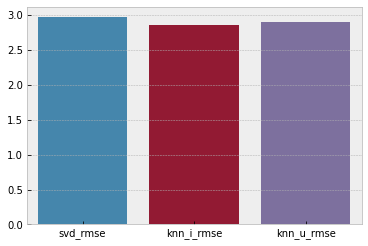

In [113]:
# Comparison of RMSE scores from different collaorative algorithms
sns.barplot(x=['svd_rmse','knn_i_rmse', 'knn_u_rmse'],y=[svd_rmse,knn_i_rmse, knn_u_rmse])

Best RMSE score is given by knn (item based), so let's use it for further analyssi

## 6. Average ratings for test users <a id="average_rating"></a>
[Go to top](#toc)

In [114]:
svd_pred_df=pd.DataFrame(svd_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
print('average prediction for test users: ',svd_pred_df['est'].mean())
print('average rating  by test users: ',svd_pred_df['rui'].mean())
print('average prediction error for test users: ',(svd_pred_df['rui']-svd_pred_df['est']).abs().mean())

average prediction for test users:  7.800217805179583
average rating  by test users:  7.850823647462162
average prediction error for test users:  2.3044087829916013


In [115]:
knn_i_pred_df=pd.DataFrame(knn_i_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
print('average prediction for test users: ',knn_i_pred_df['est'].mean())
print('average rating  by test users: ',knn_i_pred_df['rui'].mean())
print('average prediction error for test users: ',(knn_i_pred_df['rui']-knn_i_pred_df['est']).abs().mean())

average prediction for test users:  7.760249631382037
average rating  by test users:  7.850823647462162
average prediction error for test users:  2.252437466152665


In [116]:
knn_u_pred_df=pd.DataFrame(knn_u_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
print('average prediction for test users: ',knn_u_pred_df['est'].mean())
print('average rating  by test users: ',knn_u_pred_df['rui'].mean())
print('average prediction error for test users: ',(knn_u_pred_df['rui']-knn_u_pred_df['est']).abs().mean())

average prediction for test users:  7.787064696309136
average rating  by test users:  7.850823647462162
average prediction error for test users:  2.2535722447411337


## 7. Summary (findings and Inferences) <a id="summary_inferences"></a>
[Go to top](#toc)

1. Most popular phone (rated 10 by highest number of people):  
        * Overall: verykool t742
        * Amongst top users: samsung e1120       
2. Overall data is highly skewed towards 'Amazon customers' from different countries. This may also be because 'Amazon' is the biggest trader for phones in the world. Although correct 'user' names from 'Amazon' should have used.
3. Most of the authors have given the rating of '10' or '8'
4. Both knn_i(item-based) and knn_u(user-based) have roughly similar RMSE

## 8. Recommend top 5 products for test users <a id="recommend_top_5"></a>
[Go to top](#toc)

In [117]:
%%time
#recommend top 5 products for test users
top_5 = get_top_n(knn_i_pred,5)
print('Top 5 recommendations for all test users are: \n')
for key,value in top_5.items(): print(key,'-> ',value,'\n') # to print all the recommendations for all the users
#print('Top 5 recommendations for 3 users are: \n')
#for key,value in {k: v for k, v in top_5.items() if k in ['Amazon Customer','Cliente Amazon',"Client d'Amazon"]}.items(): print(key,'-> ',value,'\n')

Top 5 recommendations for all test users are: 

Luca ->  [('huawei p8 lite 2017', 9.54580999682166), ('motorola c975', 9.355991319296889), ('huawei ascend mate 7', 9.338604166135665), ('huawei ascend mate', 9.335522032799714), ('huawei g610', 9.236829921101211)] 

Andre ->  [('motorola moto g', 9.403306327732883), ('nokia 1200', 8.533290535169897), ('samsung gt b2100', 8.499674037906336), ('samsung galaxy s iii neo i9300i', 8.166709202945546), ('huawei ascend p1', 8.064538546389953)] 

Samuel ->  [('htc first', 10), ('lg g2 594708', 9.716274423343407), ('blackberry passport', 9.431273565204009), ('samsung sgh e635 sgh e630', 9.319522951000842), ('lg d686 g pro lite dual', 8.989221846729466)] 

Cliente Amazon ->  [('lg k500n', 10), ('huawei nova', 9.641332610208144), ('huawei shotx', 9.563625646324985), ('samsung s5611', 9.111330722972106), ('htc desire eye m910x', 9.056065934146138)] 

Barbara ->  [('lg dare vx9700', 10), ('alcatel one touch idol 2 mini', 9.82098153007786), ('motorola 

## 9. Results with cross_validation techniques <a id="cross_validation"></a>
[Go to top](#toc)

In [118]:
%%time
svd_cv = cross_validate(svd,revs50_, measures=['RMSE'], cv=5, verbose=False)
print('\n Mean svd cv score:', round(svd_cv['test_rmse'].mean(),2),'\n')
svd_cv


 Mean svd cv score: 2.95 

CPU times: total: 16.8 s
Wall time: 16.9 s


{'test_rmse': array([2.95021899, 2.97115911, 2.93897881, 2.94613221, 2.95849639]),
 'fit_time': (3.122933864593506,
  3.1320011615753174,
  3.1620113849639893,
  3.09799861907959,
  3.1049997806549072),
 'test_time': (0.0820000171661377,
  0.3149991035461426,
  0.07999777793884277,
  0.09300875663757324,
  0.0979926586151123)}

In [119]:
%%time
knn_i_cv = cross_validate(knn_i,revs50_, measures=['RMSE'], cv=5, verbose=False)
print('\n Mean knn_i_cv score:', round(knn_i_cv['test_rmse'].mean(),2),'\n')
knn_i_cv

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

 Mean knn_i_cv score: 2.85 

CPU times: total: 35.7 s
Wall time: 35.8 s


{'test_rmse': array([2.86091733, 2.85582123, 2.82972502, 2.87946848, 2.84445947]),
 'fit_time': (3.470057725906372,
  3.432996988296509,
  3.471011161804199,
  3.4299912452697754,
  3.4429972171783447),
 'test_time': (3.6359450817108154,
  3.8120083808898926,
  3.636906862258911,
  3.433009147644043,
  3.427009344100952)}

In [120]:
%%time
knn_u_cv = cross_validate(knn_u,revs50_, measures=['RMSE'], cv=5, verbose=False)
print('\n Mean knn_u_cv score:', round(knn_u_cv['test_rmse'].mean(),2),'\n')
knn_u_cv

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

 Mean knn_u_cv score: 2.88 

CPU times: total: 14.8 s
Wall time: 14.7 s


{'test_rmse': array([2.85883954, 2.88611776, 2.88337113, 2.90502051, 2.8898421 ]),
 'fit_time': (1.023998498916626,
  1.1129977703094482,
  1.1250007152557373,
  1.1339993476867676,
  1.396998643875122),
 'test_time': (1.722001552581787,
  1.6220769882202148,
  1.6160058975219727,
  1.6140029430389404,
  1.8140013217926025)}

<AxesSubplot:>

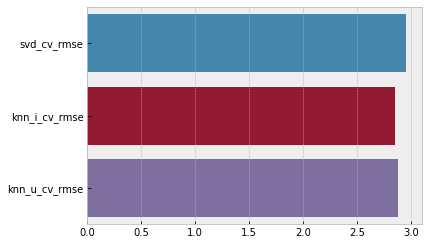

In [121]:
# Comparison of RMSE scores(mean cv) from different collaorative algorithms
sns.barplot(y=['svd_cv_rmse','knn_i_cv_rmse', 'knn_u_cv_rmse'],
            x=[svd_cv['test_rmse'].mean(),knn_i_cv['test_rmse'].mean(), knn_u_cv['test_rmse'].mean()])

Thus, for cv scores too, knn_i is giving a better performance

**10: In what business scenario you should use popularity based Recommendation Systems ?** <a id="q10"></a>
[Go to top](#toc)

> Popularity based recommendation systems can be useful in multiple scenarios like:  
> 1. When there is no data about the user and items.
> 2. When it is required to show most popular items in different categories along with personalized results like: 
>     * Most popular punjabi songs or most popular english songs on a music website/app
>     * Most popular trend in cwestern wear or traditional wear
>     * Most popular holiday packages for honeymoon trips, or bike trips or himalayan trips etc

**11: In what business scenario you should use CF based Recommendation Systems ?**  <a id="q11"></a>
[Go to top](#toc)
> Collaborative filtering is useful in scenarios like: 
> 1. Giving personalised recommendation to the user, when user history or item data is available. Some examples can be:
>     * Personalized movie recommendation of movie sites like Netflix, Amazon Prime, Youtube etc

**12: What other possible methods can you think of which can further improve the recommendation for different users ?**  <a id="q12"></a>
[Go to top](#toc)
> Other from Popularity and Collaborative Filtering, hybrid recommendation methods like Content+Collaborative method, Demographic, Utility based, and Knowledge based recommendation system can also be used.